# **TAREA 2 - MACHINE LEARNING 2**


**Integrantes:**
* Llaro Castro, Diego Renato
* Rios Meza, Jennifer Saskia
* Vargas Flores, Johanna Antonella

### **Part A: Binary Classification on Text Data**

In this part, you will implement several machine learning techniques from class to perform classification on text data. Throughout the problem, we will be working with the NLP with Disaster Tweets Kaggle competition data; the task is to predict whether or not a tweet is about a real disaster.

1. Data Loading and Splitting Load the dataset; its path in the repository is data/disaster_tweets.csv.

    - What percentage of the data are of real disasters, and what percentage is not? The description of each column is explained in the README.md contained in the data folder.
    - Split the data into 70% training and 30% testing.

In [4]:
!pip install pandas numpy scikit-learn matplotlib


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Resch\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
# LIBRERÍAS
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [12]:
# CARGA DE DATA
data = pd.read_csv("data/disaster_tweets.csv")

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [14]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [15]:
# PROPORCIÓN DE TWEETS QUE SON REALES
data['target'].value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

In [16]:
X = data.copy().drop(columns=["target"])

In [17]:
Y = data["target"]

In [18]:
X

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...


In [19]:
Y.shape

(7613,)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data, Y, train_size = .7, shuffle = True, random_state=2025)

2. **Data Pre-processing.** Since the data consists of tweets, they may contain significant amounts of noise and unprocessed content. You may or may not want to do one or all of the following. Explain the reasons for each of your decisions (why/why not).

- Convert all the words to lowercase.
- Lemmatize/stem all the words (you can use nltk as we did in the practical session).
- Strip punctuation.
- Strip stop words.
- Strip "@" and urls.
- You may come up with your own extra procedures (explain them if you do).

In [21]:
#!pip install nltk

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import string

nltk.download("stopwords")
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Resch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Resch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
import regex as re

def preprocess_string(input_string):
    string_decoded = input_string.encode("ascii", "ignore").decode() #ascii encode para eliminar caracteres corruptos o distintos al ingles
    repeated_letters = re.sub(r'(.)\1{2,}', r'\1\1', string_decoded)  # "soooo" -> "soo", existen muchos tweets que repiten letras
    lower_case = repeated_letters.lower() # lowercase strings
    split_string = lower_case.split(" ") # word by word
    no_url_words = [word for word in split_string if "://" not in word] # pick words that are not links
    no_url_string = " ".join(no_url_words) # rejoin all words into string
    no_punctuation_string = no_url_string.translate(str.maketrans("", "", string.punctuation)) # remove all punctuation
    split_string = no_punctuation_string.split(" ") # list word by word
    no_stopwords_strings = [word for word in split_string if word not in stopwords.words('english')] # remove stopwords
    stemmed_words = [lemmatizer.lemmatize(word) for word in no_stopwords_strings] # lemmatize
    rejoined_words = " ".join(stemmed_words) # rejoin string
    output_string = re.sub(r'\s+', ' ', rejoined_words).strip() # espacios multiples a un solo espacio, y aplicando trim
    return output_string

In [23]:
#%pip install ipywidgets widgetsnbextension pandas-profiling

3. **Bag of Words Model.**
  Your next tast is to extract features in order to represent each tweet using the binary "bag of words" model, as discussed in the practical session. The idea is to build a vocabulary of the words appearing in the dataset, and the to represent each tweet by a feature vector $x$ whose length is the same as the size of the vocabulary, where $x_i=1$ if the $i$'th vocabulary word appear in that tweet, and $x_i=0$ otherwise. Using `CountVectorizer`:

  * Note: Only construct feature vectors using the text in the `text` column. Ignore `keyword` and `location` for now.

In [24]:
from tqdm import tqdm

preprocessed_train_data = [preprocess_string(x) for x in tqdm(X_train['text'])]
preprocessed_test_data = [preprocess_string(x) for x in tqdm(X_test['text'])]


  0%|          | 0/5329 [00:00<?, ?it/s]

100%|██████████| 2284/2284 [00:11<00:00, 199.18it/s]


  * Set the option `binary=True` to ensure the feature vectors are binary.
  * Pick a threshold $M$ (using option `min_df=M`) such that only words that appear in at least $M$ are included in the vocabulary.
  * Make sure you fit `CountVectorizer` only on your training set, and use the same instance to process both training and testing observations.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True, min_df = 3)
X_train = vectorizer.fit_transform(preprocessed_train_data)
X_test = vectorizer.transform(preprocessed_test_data)
feature_names = vectorizer.get_feature_names_out()

In [26]:
X_train.shape

(5329, 3103)

In [27]:
feature_names

array(['0104', '010401', '05', ..., 'zombie', 'zone', 'zouma'],
      shape=(3103,), dtype=object)

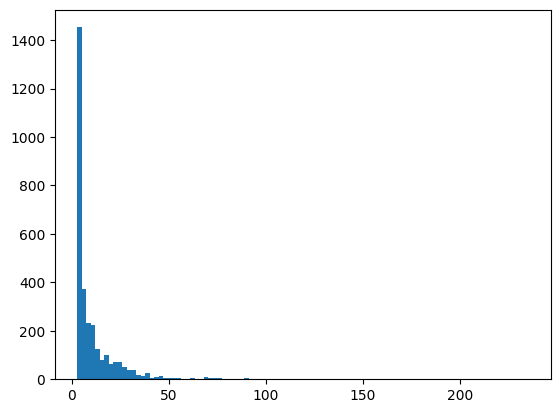

In [28]:
plt.hist(X_train.toarray().sum(0), bins = 100)
plt.show()

In [29]:
np.quantile(X_train.toarray().sum(0), [.1, .25, .5, .75, .9])

array([ 3.,  4.,  6., 13., 26.])

  * Report the total number of words in your vocabulary.

In [30]:
print("Número total de palabras en el vocabulario: ",feature_names.size)

Número total de palabras en el vocabulario:  3103


4. **Logistic Regression.**
  We will train and evaluate several logistic regression models. We will specifically be using the F1 score for evaluation.

  * Train a logistic regression model without regularization terms. By default, `sklearn` uses L2 regularization, but you can turn it off using the `penalty` parameter. Report the F1 score for the training and testing set. Comment whether you observe any issues with overfitting or underfitting.

In [31]:
# LIBRERÍAS PARA MÉTRICAS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

def show_metric(my_metric):
  return "{:.2f}%".format(my_metric * 100)

In [32]:
clf_lNone = LogisticRegression(tol=1e-2, solver="saga", penalty=None, random_state=2025)
clf_lNone.fit(X_train, y_train)

y_train_pred_lNone = clf_lNone.predict(X_train)
y_test_pred_lNone = clf_lNone.predict(X_test)

print("Training Set - F1 score sin penalización: {}".format(show_metric(f1_score(y_train, y_train_pred_lNone))))
print("Testing Set  - score sin penalización: {}".format(show_metric(f1_score(y_test, y_test_pred_lNone))))

Training Set - F1 score sin penalización: 95.12%
Testing Set  - score sin penalización: 72.59%


  * Train a logistic regression model with L1 regularization, making sure to use *some* procedure to pick the optimal penalty parameter. Report the performance of the final model and comment.

In [33]:
clf_l1 = LogisticRegression(tol=1e-2, solver="saga", penalty='l1', random_state=2025)
clf_l1.fit(X_train, y_train)
y_train_pred_l1 = clf_l1.predict(X_train)
y_test_pred_l1 = clf_l1.predict(X_test)

print("Training Set - F1 score con penalización L1: {}".format(show_metric(f1_score(y_train, y_train_pred_l1))))
print("Testing Set  - F1 score con penalización L1: {}".format(show_metric(f1_score(y_test, y_test_pred_l1))))

Training Set - F1 score con penalización L1: 84.93%
Testing Set  - F1 score con penalización L1: 74.62%


* Same as the previous point, but now with L2 regularization.

In [34]:
clf_l2 = LogisticRegression(tol=1e-2, solver="saga", penalty='l2', random_state=2025)
clf_l2.fit(X_train, y_train)
y_train_pred_l2 = clf_l2.predict(X_train)
y_test_pred_2 = clf_l2.predict(X_test)

print("Training Set - F1 score con penalización L2: {}".format(show_metric(f1_score(y_train, y_train_pred_l2))))
print("Testing Set  - F1 score con penalización L2: {}".format(show_metric(f1_score(y_test, y_test_pred_2))))

Training Set - F1 score con penalización L2: 88.57%
Testing Set  - F1 score con penalización L2: 75.08%


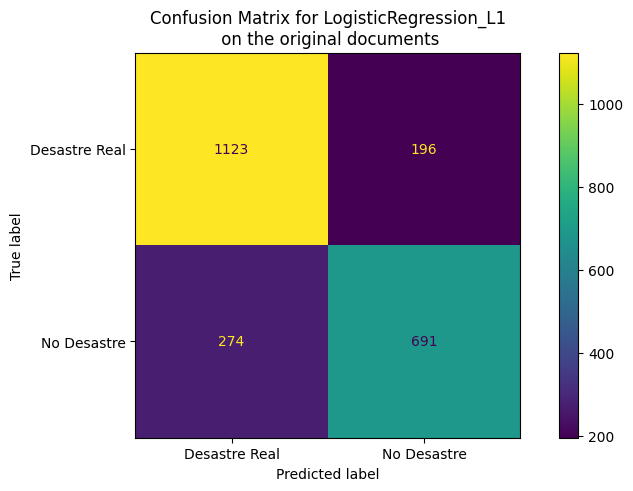

In [35]:
# MATRIZ DE CONFUSIÓN
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_l1, ax=ax)
ax.xaxis.set_ticklabels(["Desastre Real","No Desastre"])
ax.yaxis.set_ticklabels(["Desastre Real","No Desastre"])
_ = ax.set_title(
    f"Confusion Matrix for {clf_l1.__class__.__name__}_L1\n on the original documents"
)

* Which one of the three classifiers performed best on your training and testing set? Did you observe any overfitting and did regularization help reduce it? Support your answers with the classifier performance you got.

In [36]:
display(Markdown(
f"""
> El modelo que mejor rendimiento tuvo en ambos data sets fue la Regresion Logística con L2
>
> Alcanzó el mejor F1-Score en el test set **{show_metric(f1_score(y_test, y_test_pred_2))}** y tuvo un rendimiento en el train set de **{show_metric(f1_score(y_train, y_train_pred_l2))}**, indicando una buena generalización.
>
> El modelo no regularizado claramente tuvo `overfitting` ya que de **{show_metric(f1_score(y_train, y_train_pred_lNone))}%** pasó a **{show_metric(f1_score(y_test, y_test_pred_lNone))}%**, la penalización usada en los otros modelos sí redujo el overfitting y mejoró el rendimiento en el test set.
"""
))


> El modelo que mejor rendimiento tuvo en ambos data sets fue la Regresion Logística con L2
>
> Alcanzó el mejor F1-Score en el test set **75.08%** y tuvo un rendimiento en el train set de **88.57%**, indicando una buena generalización.
>
> El modelo no regularizado claramente tuvo `overfitting` ya que de **95.12%%** pasó a **72.59%%**, la penalización usada en los otros modelos sí redujo el overfitting y mejoró el rendimiento en el test set.


* Inspect the weight vector of the classifier with L1 regularization. What are the most important words for deciding whether a tweet is about a real disaster or not?

In [37]:
w = clf_l1.coef_[0]
vocabulario = np.array(vectorizer.get_feature_names_out())# palabras

# Top palabras positivas (clase 1 = "Desastre real") y negativas (clase 0 = "No Desastre")
top_positivas = np.argsort(w)[-15:][::-1]
top_negativas = np.argsort(w)[:15]

print("Top palabras positivas que contribuyen a target 1:")
print(vocabulario[top_positivas])

print("\nTop palabras negativas que contribuyen a target 0:")
print(vocabulario[top_negativas])

# L1 vuelve a 0 features
# Contamos cuantas features son realmente usadas(non-zero w)
non_zero = np.sum(w != 0)
print(f"\nNon-zero weights: {non_zero}/{len(w)}")

Top palabras positivas que contribuyen a target 1:
['spill' 'hiroshima' 'typhoon' 'wildfire' 'earthquake' 'migrant'
 'derailment' 'massacre' 'bombing' 'killed' 'suicide' 'mh370' 'horror'
 'outbreak' 'japan']

Top palabras negativas que contribuyen a target 0:
['ebay' 'bag' 'cake' 'longer' 'electrocute' 'better' 'love' 'character'
 'best' 'welcome' 'mode' 'ticket' 'nowplaying' 'full' 'pile']

Non-zero weights: 978/3103


5. **Bernoulli Naive Bayes.**
  Just like point 4, but now using the Bernoulli Naive Bayes algorithm for prediction.

  * Write the necessary funtions to perform the Bernoulli Naive Bayes procedure, like we did in the practical session. Use Laplace smoothing with $\alpha=1$.
  * Report the F1 score for the training and testing sets. Comment.

In [38]:
X_train.shape


(5329, 3103)

In [39]:
class BernoulliNaiveBayesClassifier:
    """
    Naive Bayes Classifier con Laplace smoothing para clasificación multiclase.
    """
    def __init__(self, alpha=1.0, K=2):
        """
        Parámetros:
        -----------
        alpha : Parámetro de Laplace smoothing
        K : Número de clases
        """
        self.alpha = alpha
        self.K = K
        self.psis = None  # P(x|y) - probabilidades de features dada la clase
        self.phis = None  # P(y) - probabilidades a priori de las clases
        self.n = None
        self.d = None

    def fit(self, X, y):
        """
        Entrena el modelo Naive Bayes.

        Parámetros:
        -----------
        X : sparse matrix, shape (n_samples, n_features)
            Datos de entrenamiento
        y : array-like, shape (n_samples,)
            Etiquetas de clase
        """
        y = np.array(y)
        self.n = X.shape[0]  # número de ejemplos
        self.d = X.shape[1]  # número de features

        # Inicializar parámetros
        self.psis = np.zeros([self.K, self.d])
        self.phis = np.zeros([self.K])

        # Calcular parámetros para cada clase
        for k in range(self.K):
            X_k = X[y == k]
            n_k = X_k.shape[0]

            # Laplace smoothing
            self.psis[k] = (X_k.sum(axis=0) + self.alpha) / (n_k + 2 * self.alpha)

            # Probabilidad a priori de la clase
            self.phis[k] = n_k / float(self.n)

        return self

    def predict_log_proba(self, X):
        """
        Calcula log-probabilidades para cada clase.

        Retorna:
        --------
        logpyx : array, shape (K, n_samples)
            Log-probabilidades de cada clase para cada ejemplo
        """
        n, d = X.shape
        x = np.reshape(X.toarray(), (1, n, d))
        psis = np.reshape(self.psis, (self.K, 1, d))

        # Clip para evitar log(0)
        psis = psis.clip(1e-14, 1 - 1e-14)

        # Calcular log-probabilidades
        logpy = np.log(self.phis).reshape([self.K, 1])
        logpxy = x * np.log(psis) + (1 - x) * np.log(1 - psis)
        logpyx = logpxy.sum(axis=2) + logpy

        return logpyx.reshape([self.K, n])
    def predict(self, X):
        """
        Predice la clase para cada ejemplo.

        Retorna:
        --------
        predictions : array, shape (n_samples,)
            Clase predicha para cada ejemplo
        """
        logpyx = self.predict_log_proba(X)
        return logpyx.argmax(axis=0).flatten()

    def score(self, X, y):
        """
        Calcula el score del modelo.
        """
        y_pred = self.predict(X)

        return f1_score(y, y_pred)

    def get_class_priors(self):
        """Retorna las probabilidades a priori de cada clase."""
        return self.phis

In [40]:
nb_model = BernoulliNaiveBayesClassifier(alpha=1.0, K=2)

nb_model.fit(X_train, y_train)

print("Probabilidades de clase:", nb_model.get_class_priors())

# Predicciones
y_train_pred = nb_model.predict(X_train)
y_test_pred = nb_model.predict(X_test)

f1_train = nb_model.score(X_train, y_train)
f1_test = nb_model.score(X_test, y_test)

print(f"Training Set - F1 Score: {f1_train:.2%}")
print(f"Testing Set  - F1 Score: {f1_test:.2%}")

Probabilidades de clase: [0.56727341 0.43272659]
Training Set - F1 Score: 82.26%
Testing Set  - F1 Score: 74.55%


In [41]:
display(Markdown(
f"""
> Naive Bayes obtuvo menor **F1-Score** que LR L1 y L2 pero tuvo la menor diferencia entre Trainig F1 Score {f1_train:.2%} y su Testing F1 Score `{f1_test:.2%}`, indicando el menor `Overfitting` entre todos los modelos.
"""
))


> Naive Bayes obtuvo menor **F1-Score** que LR L1 y L2 pero tuvo la menor diferencia entre Trainig F1 Score 82.26% y su Testing F1 Score `74.55%`, indicando el menor `Overfitting` entre todos los modelos.


6. **N-gram model.**
  We will extend what we learned in class. The $N$-gram model uses contiguous sequences of words; e.g., for $N=2$, the text "Alice fell down the rabbit hole" consists creates a vocabulary with the 2-grams ["Alice fell", "fell down", "down the", "the rabbit", "rabbit hole"] **may also** contain the 1-grams ["Alice", "fell", "down", "the", "rabbit", "hole"].

  * Use `CountVectorizer` to create 2-grams. You may set the option `ngram_range=(2,2)` to use only sequences of two words.
  * Again, choose a threshold $M$ too use only 2-grams that appear in at least $M$ tweets. Justify your choice of $M$.

In [42]:
vectorizer_Ngram = CountVectorizer(binary=True, ngram_range=(2,2))
X_train_Ngram = vectorizer_Ngram.fit_transform(preprocessed_train_data)
X_test_Ngram = vectorizer_Ngram.transform(preprocessed_test_data)
feature_names_Ngram = vectorizer_Ngram.get_feature_names_out()

In [43]:
X_train_Ngram.shape

(5329, 34257)

In [44]:
feature_names_Ngram

array(['001116 utc20150805', '005225 utc20150805', '010156 okinawa', ...,
       'zss sw', 'zumiez location', 'zxathetis okay'],
      shape=(34257,), dtype=object)

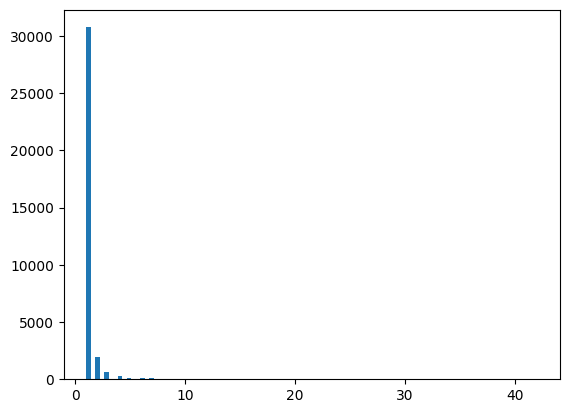

In [45]:
plt.hist(X_train_Ngram.toarray().sum(0), bins = 100)
plt.show()

In [46]:
np.quantile(X_train_Ngram.toarray().sum(0), [.1, .25, .5, .75, .9])

array([1., 1., 1., 1., 2.])

> Se observa que el 90% de pares de palabras solo aparece una vez, así que se cojera $M = 2$, aunque al ser bigramas, la frecuencia con la que aparecen es menos común en los tweets.

In [47]:
vectorizer_Ngram = CountVectorizer(binary=True, ngram_range=(2,2), min_df=2)
X_train_Ngram = vectorizer_Ngram.fit_transform(preprocessed_train_data)
X_test_Ngram = vectorizer_Ngram.transform(preprocessed_test_data)
feature_names_Ngram = vectorizer_Ngram.get_feature_names_out()

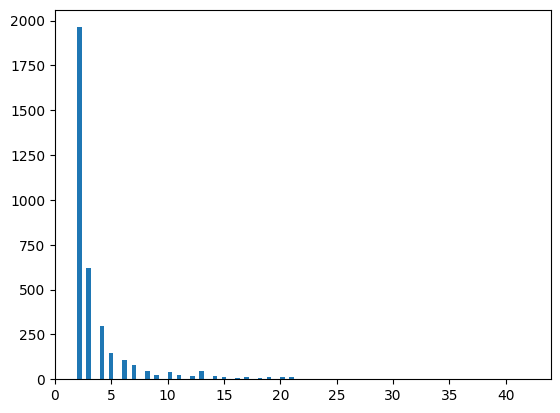

In [48]:
plt.hist(X_train_Ngram.toarray().sum(0), bins = 100)
plt.show()

In [49]:
np.quantile(X_train_Ngram.toarray().sum(0), [.1, .25, .5, .75, .9])

array([2., 2., 2., 4., 7.])

In [50]:
feature_names_Ngram

array(['001116 utc20150805', '005225 utc20150805', '0104 utc5km', ...,
       'zone coming', 'zone dont', 'zss sw'], shape=(3506,), dtype=object)

  * Report the total number of 2-grams in your vocabulary.


In [51]:
print("Número total 2-grams en el vocabulario: ",feature_names_Ngram.size)

Número total 2-grams en el vocabulario:  3506


  * Take 10 2-grams from your vocabulary and print them out.

In [52]:
import random
random.seed(2025)
for i in range(10):
    numero = random.randint(0,X_train_Ngram.shape[1])
    print(f"2-Gram - indice {numero} : {feature_names_Ngram[numero]}")

2-Gram - indice 2284 : one day
2-Gram - indice 338 : bbcnews as
2-Gram - indice 2645 : ruin thing
2-Gram - indice 3430 : world extreme
2-Gram - indice 1956 : man really
2-Gram - indice 709 : cover clever
2-Gram - indice 2167 : new content
2-Gram - indice 1 : 005225 utc20150805
2-Gram - indice 1520 : hope discovery
2-Gram - indice 1538 : hot seat


  * Implement a logistic regression (choose one of any of the specifications, i.e. the type of regularization, if any) and a Bernouli classifier to train on 2-grams (you may reuse code from parts 4 and 5).
  * Report your results on the training and the testing set.


In [53]:
clf_l2_Ngram = LogisticRegression(tol=1e-2, solver="saga", penalty='l2', random_state=2025)
clf_l2_Ngram.fit(X_train_Ngram, y_train)
y_train_pred_l2_Ngram = clf_l2_Ngram.predict(X_train_Ngram)
y_test_pred_l2_Ngram  = clf_l2_Ngram.predict(X_test_Ngram)

print("Training Set - F1 score con penalización L2: {}".format(show_metric(f1_score(y_train, y_train_pred_l2_Ngram))))
print("Testing Set  - F1 score con penalización L2: {}".format(show_metric(f1_score(y_test, y_test_pred_l2_Ngram))))

Training Set - F1 score con penalización L2: 71.30%
Testing Set  - F1 score con penalización L2: 56.14%


In [54]:
# BERNOULLI
nb_model = BernoulliNaiveBayesClassifier(alpha=1.0, K=2)

nb_model.fit(X_train_Ngram, y_train)

# PREDICCIONES
y_train_pred = nb_model.predict(X_train_Ngram)
y_test_pred = nb_model.predict(X_test_Ngram)

f1_train_nb = nb_model.score(X_train_Ngram, y_train)
f1_test_nb = nb_model.score(X_test_Ngram, y_test)

print(f"Bernoulli Training Set - F1 Score: {f1_train_nb:.2%}")
print(f"Bernoulli Testing Set  - F1 Score: {f1_test_nb:.2%}")

Bernoulli Training Set - F1 Score: 61.58%
Bernoulli Testing Set  - F1 Score: 48.55%


* Do these results differ significantly from those using the bag of words model? Discuss.

In [55]:
# VARIABLES PARA MÉTRICAS
l2_train = f1_score(y_train, y_train_pred_l2)
l2_test = f1_score(y_test, y_test_pred_2)
diff_l2 = show_metric(l2_train - l2_test)

l2_Ngram_train = f1_score(y_train, y_train_pred_l2_Ngram)
l2_Ngram_test = f1_score(y_test, y_test_pred_l2_Ngram)
diff_l2_ngram = show_metric(l2_Ngram_train - l2_Ngram_test)

NB_train = f1_train_nb
NB_test = f1_test_nb
diff_nb = show_metric(NB_train - NB_test)

data_table = [
    {"Modelo": "Log Reg L2", "F1 Train": show_metric(l2_train), "F1 Test": show_metric(l2_test), "Diff Train y Test": diff_l2},
    {"Modelo": "Log Reg L2 (2-grams) ", "F1 Train": show_metric(l2_Ngram_train), "F1 Test": show_metric(l2_Ngram_test), "Diff Train y Test": diff_l2_ngram},
    {"Modelo": "Bernoulli (2-grams)", "F1 Train": show_metric(NB_train), "F1 Test": show_metric(NB_test), "Diff Train y Test": diff_nb}
]

# CREACIÓN DE CADENA DE TABLA DE MARKDOWN
table_md = "| Modelo | F1 Train | F1 Test | Diff Train y Test|\n"
table_md += "|------|-------|-------|-------|\n"
for row in data_table:
    table_md += f"| {row['Modelo']} | {row['F1 Train']} | {row['F1 Test']} |{row['Diff Train y Test']} |\n"

# DISPLAY AS MARKDOWN
display(Markdown("""
> Las diferencias son significativamente peores.
> Esto se puede deber a que cada bigrama es mucho más específico que aparezca en cada documento, por lo que el modelo tiene menos ejemplos para aprender.
> Se tuvo una ligera mejora en la diferencia entre el Train y Test en el modelo de Bernoulli pero las predicciones son aún más bajas.
"""))
display(Markdown(table_md))


> Las diferencias son significativamente peores.
> Esto se puede deber a que cada bigrama es mucho más específico que aparezca en cada documento, por lo que el modelo tiene menos ejemplos para aprender.
> Se tuvo una ligera mejora en la diferencia entre el Train y Test en el modelo de Bernoulli pero las predicciones son aún más bajas.


| Modelo | F1 Train | F1 Test | Diff Train y Test|
|------|-------|-------|-------|
| Log Reg L2 | 88.57% | 75.08% |13.49% |
| Log Reg L2 (2-grams)  | 71.30% | 56.14% |15.16% |
| Bernoulli (2-grams) | 61.58% | 48.55% |13.03% |


### **Part B: Support Vector Machine and Overfitting.**

We will examine whether a low or high $C$ parameter for the objective function of the SVM algorithm can lead to overfitting.

1. **Generate Data**
  
  * Generate data with two features and two classes, such that the classes are barely linearly separable.

In [56]:
# LIBRERÍAS
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score

# GENERAR DATA: 2 FEATURES, 2 CLASES, LÍNEA LIMÍTROFE
X, y = make_classification(
    n_samples=300,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=0.8,
    flip_y=0.05,         # algo de ruido
    random_state=42
)

# DIVISIÓN EN TRAIN/TEST (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

2. **Test a Variety of C's**

  * Compute the cross-validation error rates for support vector classifiers with a range of $C$ values. How many training observations are misclassified for each value of $C$ considered, and how does this relate to the cross-validation errors obtained?
  * Generate an appropriate test data set, and compute the test errors corresponding to each of the values of $C$ considered. Which value of $C$ leads to the fewest test errors, and how does this compare to the values of C that yield the fewest training errors and the fewest cross-validation errors?
  * Discuss your results

In [57]:
# DEFINIR VALORES DE C A PROBAR
C_values = [0.01, 0.1, 1, 10, 100]
train_errors, cv_errors, test_errors = [], [], []

In [58]:
# ENTRENAR Y EVALUAR SVMs
for C in C_values:
    svm = SVC(kernel='linear', C=C, random_state=42)
    svm.fit(X_train, y_train)

    # ERROR EN ENTRENAMIENTO
    train_error = 1 - svm.score(X_train, y_train)
    train_errors.append(train_error)

    # ERROR EN VALIDACIÓN CRUZADA (5-fold)
    cv_error = 1 - cross_val_score(svm, X_train, y_train, cv=5).mean()
    cv_errors.append(cv_error)

    # ERROR EN TEST
    test_error = 1 - svm.score(X_test, y_test)
    test_errors.append(test_error)

In [59]:
# TABLA DE RESULTADOS
print("RESULTADOS SVM (lineal) PARA DIFERENTES C")
print(f"{'C':>10} | {'Train Err':>10} | {'CV Err':>10} | {'Test Err':>10}")
print("-" * 45)
for i, C in enumerate(C_values):
    print(f"{C:>10} | {train_errors[i]:>10.3f} | {cv_errors[i]:>10.3f} | {test_errors[i]:>10.3f}")


RESULTADOS SVM (lineal) PARA DIFERENTES C
         C |  Train Err |     CV Err |   Test Err
---------------------------------------------
      0.01 |      0.133 |      0.133 |      0.156
       0.1 |      0.143 |      0.157 |      0.156
         1 |      0.138 |      0.157 |      0.156
        10 |      0.138 |      0.152 |      0.156
       100 |      0.138 |      0.148 |      0.156


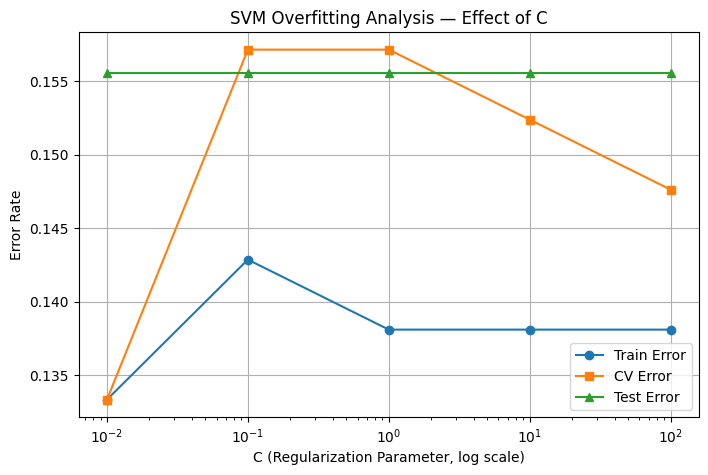

In [60]:
# VISUALIZACIÓN DE LOS ERRORES
plt.figure(figsize=(8,5))
plt.plot(C_values, train_errors, marker='o', label="Train Error")
plt.plot(C_values, cv_errors, marker='s', label="CV Error")
plt.plot(C_values, test_errors, marker='^', label="Test Error")
plt.xscale('log')
plt.xlabel("C (Regularization Parameter, log scale)")
plt.ylabel("Error Rate")
plt.title("SVM Overfitting Analysis — Effect of C")
plt.legend()
plt.grid(True)
plt.show()

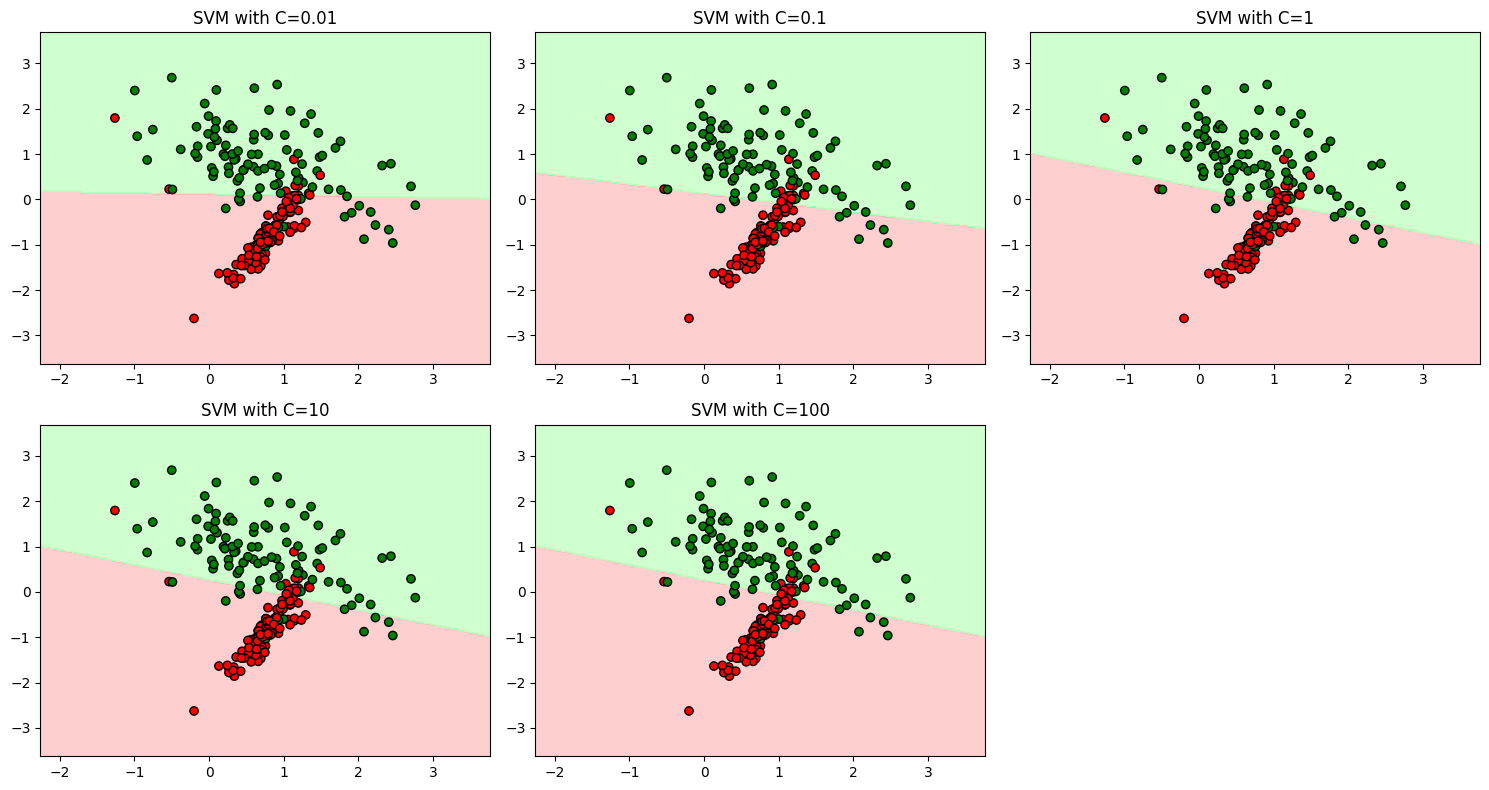

In [61]:
# VISUALIZACIÓN DE FRONTERAS DE DECISIÓN
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15, 8))
for i, C in enumerate(C_values):
    svm = SVC(kernel='linear', C=C, random_state=42)
    svm.fit(X_train, y_train)
    plt.subplot(2, 3, i+1)

    # Malla para visualizar fronteras
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=ListedColormap(['#FFBBBB', '#BBFFBB']), alpha=0.7)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(['red', 'green']), edgecolors='k')
    plt.title(f"SVM with C={C}")
plt.tight_layout()
plt.show()

### **Part C: Regression trees on Carseats data.**

We will be using more data from the `ISLP` package. In this case, the data corresponds to children's car seats sales. More information can be found in the `README.md` file of the `data` folder. We seek to predict the values in the `Sales` column using regression trees.

1. **Process Data**
  You will need the `ISLP` package installed. With it, you can run `from ISLP import load_data()` to load the function that will gather the data for you.

  * Load the data using `load_data("Carseats")`
  * Split the data into a training set (70%) and a testing set (30%).

In [62]:
!pip install ISLP
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from ISLP import load_data
carseats = load_data("Carseats")
carseats.head()



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Resch\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [63]:
# CARGAR LOS DATOS
carseats = load_data("Carseats")
print("Datos Carseats cargados correctamente.\n")
print(carseats.head())

Datos Carseats cargados correctamente.

   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  


In [64]:
# DIVIDIR EN TRAIN Y TEST (70% / 30%)
X = carseats.drop(columns=["Sales"])
y = carseats["Sales"]

# CONVERTIR VARIABLES CATEGÓRICAS A DUMMIES (One-Hot Encoding)
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Tamaño del set de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del set de prueba: {X_test.shape[0]} muestras")

Tamaño del set de entrenamiento: 280 muestras
Tamaño del set de prueba: 120 muestras


2. **Fitting the Trees**

  * Fit a regression tree to the training set. Plot the tree and interpret the results. Report the test MSE.
  * Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

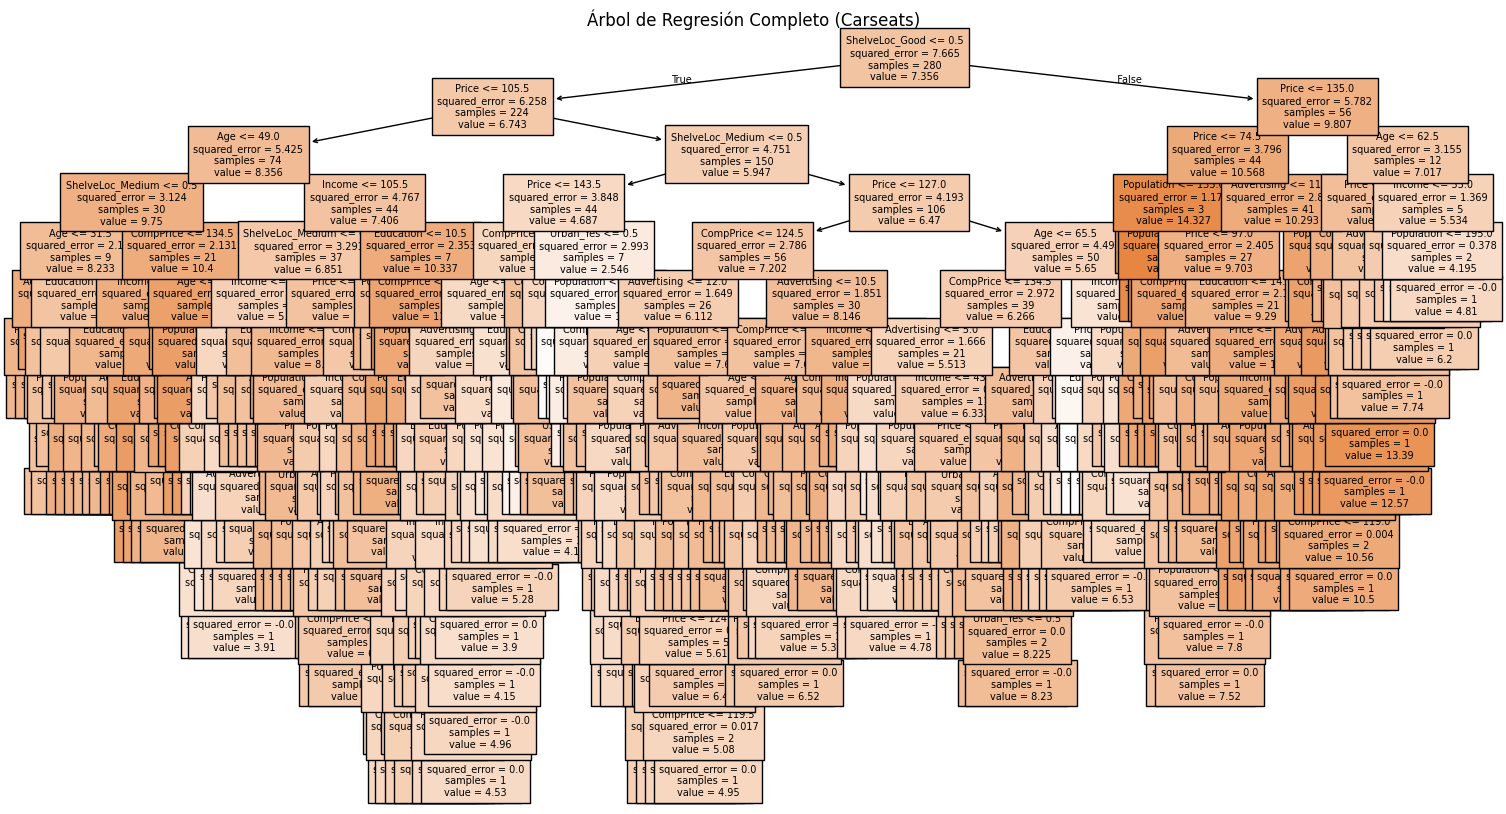

In [65]:
# AJUSTAR UN ÁRBOL DE REGRESIÓN COMPLETO
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

# VISUALIZAR EL ÁRBOL
plt.figure(figsize=(18, 10))
plot_tree(tree_reg, filled=True, feature_names=X.columns, fontsize=7)
plt.title("Árbol de Regresión Completo (Carseats)")
plt.show()

In [66]:
# CALCULAR EL ERROR EN TEST
y_pred = tree_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
print(f" MSE del Árbol Completo en Test: {mse_test:.3f}")

 MSE del Árbol Completo en Test: 4.805


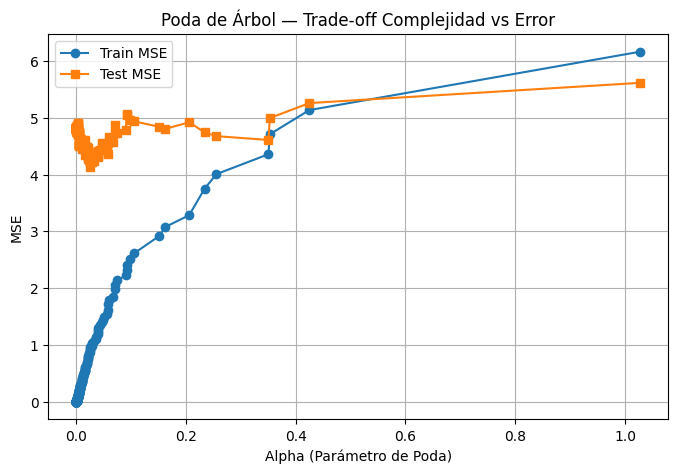

In [67]:
# PODA MEDIANTE VALIDACIÓN CRUZADA PARA SELECCIONAR COMPLEJIDAD ÓPTIMA
path = tree_reg.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]  # excluye el valor más grande (hojas vacías)

train_mses, test_mses = [], []

for alpha in ccp_alphas:
    reg_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
    reg_tree.fit(X_train, y_train)
    train_mses.append(mean_squared_error(y_train, reg_tree.predict(X_train)))
    test_mses.append(mean_squared_error(y_test, reg_tree.predict(X_test)))

# GRÁFICO DEL MSE VS. α
plt.figure(figsize=(8,5))
plt.plot(ccp_alphas, train_mses, marker='o', label='Train MSE')
plt.plot(ccp_alphas, test_mses, marker='s', label='Test MSE')
plt.xlabel("Alpha (Parámetro de Poda)")
plt.ylabel("MSE")
plt.title("Poda de Árbol — Trade-off Complejidad vs Error")
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# SELECCIONAR EL α ÓPTIMO
optimal_alpha = ccp_alphas[np.argmin(test_mses)]
print(f"Alpha óptimo según validación: {optimal_alpha:.5f}")

Alpha óptimo según validación: 0.02485


In [69]:
# ENTRENAR EL ÁRBOL PODADO FINAL
pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=optimal_alpha)
pruned_tree.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,np.float64(0....5127040816363)


In [70]:
# EVALUACIÓN EN TEST
y_pred_pruned = pruned_tree.predict(X_test)
mse_test_pruned = mean_squared_error(y_test, y_pred_pruned)
print(f" MSE del Árbol Podado en Test: {mse_test_pruned:.3f}")

 MSE del Árbol Podado en Test: 4.139


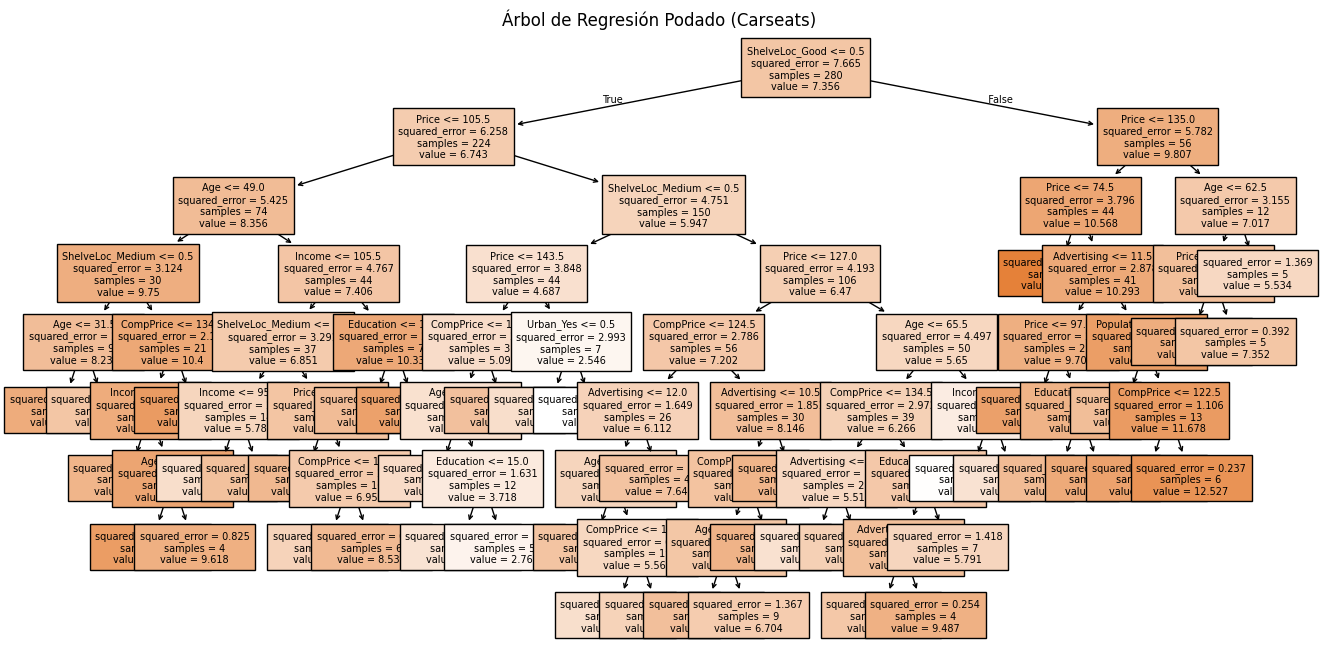

In [71]:
# VISUALIZACIÓN DEL ÁRBOL PODADO
plt.figure(figsize=(16, 8))
plot_tree(pruned_tree, filled=True, feature_names=X.columns, fontsize=7)
plt.title("Árbol de Regresión Podado (Carseats)")
plt.show()